In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
xgb.__version__

''

In [4]:
df=pd.read_csv('../input/train2016_withy.csv')

In [5]:
df['Q4']=df['month'].apply(lambda u: u>=10)

In [18]:
def mae(y,ypred=None):
    if ypred is None: ypred=np.median(y)
    return np.mean(np.abs(y-ypred))

In [7]:
#df=df.loc[np.random.permutation(df.index)]

In [8]:
testdf=df[df['Q4']]
testdf.shape

(8542, 98)

In [9]:
testx=testdf.drop(['parcelid','logerror',"Q4",'month','year'],axis=1)
testy=testdf['logerror']

In [10]:
traindf=df[~df['Q4']].copy()
traindf.shape

(81733, 98)

In [11]:
trainx=traindf.drop(['parcelid','logerror', "Q4",'month','year'],axis=1)
trainy=traindf['logerror']

In [12]:
if 0:
    th=0.2
    trainy[trainy>th]=th
    trainy[trainy<-th]=-th

In [13]:
trainx.shape

(81733, 93)

In [14]:
mae(testy),mae(trainy),np.mean(np.abs(trainy))

(0.06569923905408559, 0.06835601531817634, 0.06861247231840874)

In [15]:
#split = 80000
#x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(trainx, label=trainy )
#d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(testx, label=testy )



Building DMatrix...


In [100]:
d_train = xgb.DMatrix(fs.X, label=fs.y)

In [16]:
print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:smoothl1'
#params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 8
#params['subsample'] = 0.7
#params['colsample_bytree'] = 0.8
params['silent'] = 1
params['base_score'] = 0#np.median(trainy)
params['min_child_weight']=50
params['tree_method']='hist'

watchlist = [(d_train, 'train')] #+ [ (d_test,'eval')]
clf = xgb.train(params, d_train, 70, watchlist, early_stopping_rounds=50, verbose_eval=10)


Training ...
[0]	train-mae:0.067896
Will train until train-mae hasn't improved in 50 rounds.
[10]	train-mae:0.066161
[20]	train-mae:0.065474
[30]	train-mae:0.064909
[40]	train-mae:0.064488
[50]	train-mae:0.064106
[60]	train-mae:0.063654
[69]	train-mae:0.063439


In [20]:
mae(trainy,clf.predict(d_train)),mae(testy,clf.predict(xgb.DMatrix(testx)))

(0.06343862685138285, 0.0656573899311039)

In [21]:
clf.best_ntree_limit

70

In [22]:
#print clf.get_dump(dump_format='text')[7]

In [23]:
import json
trees=[json.loads(u) for u in clf.get_dump(dump_format='json')[:clf.best_ntree_limit]]
len(trees)

70

In [24]:
def parse_tree_(node):
    if 'leaf' in node:
        return [[]]
    nodeid=node['nodeid']
    split=node['split']
    if 'split_condition' not in node:
        print node
        raise 1
    split_cond=node['split_condition']
    yes=node['yes']
    no=node['no']
    missing=node['missing']
    children1=parse_tree_([u for u in node["children"] if u['nodeid']==yes][0])
    children2=parse_tree_([u for u in node["children"] if u['nodeid']==no][0])
    cond1=[('yes',split,split_cond)]
    cond2=[('no',split,split_cond)]
    if missing==yes:
        cond1.append(('missing',split))
    elif missing==no:
        cond2.append(('missing',split))
    else:
        raise 2
    ret1=[[cond1]+u for u in children1]
    ret2=[[cond2]+u for u in children2]
    return ret1+ret2
    
def parse_tree(node):
    ret=parse_tree_(node)
    ret=[tuple(tuple(v) for v in u) for u in ret]
    return ret
        

In [25]:
#parse_tree(trees[0])

In [26]:
def enumerate_all_conds(tree):
    ret=[]
    cond_list=(parse_tree(tree))
    for cond in cond_list:
        for i in range(len(cond)):
            ret.append(cond[:i+1])
    return ret

In [27]:
cond_list=(enumerate_all_conds(trees[8]))
len(cond_list)

379

In [28]:
def value_cond_tuple (df,cond):
    #print cond
    col=cond[1]
    if cond[0]=='missing':
        return np.isnan(df[col])
    else:
        split_val=cond[2]
        if cond[0]=='yes':
            return df[col]<split_val
        elif cond[0]=='no':
            return df[col]>=split_val
        else:
            raise "never be here"
def value_cond_single(df,conds):
    return reduce(lambda u,v: u | v, [value_cond_tuple(df,cond) for cond in conds])
def value_cond(df,conds):
    return reduce(lambda u,v: u & v, [value_cond_single(df,cond) for cond in conds])
def cond_trees(trees):
    cond_lists=reduce(lambda u,v: u+v, [enumerate_all_conds(tree) for tree in trees])
    cond_lists=list(set(cond_lists))
    print len(cond_lists)
    return cond_lists 
def value_trees(df,trees):
    cond_lists=cond_trees(trees)
    return cond_lists, [value_cond(df, conds) for conds in cond_lists]

In [29]:
len(trees)

70

In [30]:
cond_lists=cond_trees(trees)

8172


In [31]:
df.values.nbytes/1024.**2

67.49687194824219

In [32]:
from sklearn.utils import resample
import scipy.stats 

In [33]:

def evaluate_cond(cond,X,y,n=500):
    v=value_cond(X,cond)
    newy=y[v]
    lst=[]
    for _ in range(n):
        ry=resample(newy)
        lst.append(np.median(ry))
    m,s=np.mean(lst),np.std(lst)
    p_values = scipy.stats.norm.sf(abs(m/s))*2
    yy=y-v*m
    #print y*ymask
    #print yy*ymask
    if 0:
        gain1 = mae(y,0)-mae(yy,0)
        gain2=mae(y*ymask,0)-mae(yy*ymask,0)
        gain = gain2 if gain2!=0 else gain1
    elif 0:
        if np.sum(ymask&v)>0:
            gain=-1
        else:
            gain=mae(y)-mae(yy)
    else:
        gain=mae(y,0)-mae(yy,0)
    return float(np.sum(v)), float(gain), float(m),float(s),float(np.round(p_values,6))
        

In [34]:
c=evaluate_cond(cond_lists[123],trainx,trainy)
c

(65.0,
 7.76481959549602e-07,
 0.011821400000000001,
 0.009231006556167102,
 0.200328)

In [35]:
import findspark
findspark.init()

In [36]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',4)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','20G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local[6]")

/home/spark/software/spark-2.0.1-bin-hadoop2.7/python/pyspark/sql/context.py:487: DeprecationWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  DeprecationWarning)


In [37]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [38]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [49]:
class FeatSel(object):
    def __init__(self,rawX,rawy,conds_list):
        self.X=rawX.copy()
        #self.b=np.median(rawy*ymask)
        #self.y=rawy-self.b
        self.y=rawy 
        self.conds_list=conds_list
        self.feats=[]
    def updatey(self,feat,stat):
        v= value_cond(self.X,feat)
        vy=self.y[v]
        oldy=self.y
        self.y=self.y-v*stat['m']
        #print np.median(vy) ,np.median(self.y[v])        
        return mae(oldy,0)-mae(self.y,0)
    def step(self):
        Xy_bc=sc.broadcast((self.X,self.y))
        condsDF=sc.parallelize(self.conds_list,1000)
        print "#feats", condsDF.count()      
        eval_results=condsDF.map(lambda u: evaluate_cond(u,X=Xy_bc.value[0],y=Xy_bc.value[1])).collect()
        df=pd.DataFrame(eval_results,columns=['n','gain','m','sd','p'])
        df=df[(df['p']<0.02) & (df['gain']>0)]
        if df.shape[0]==0:
            print "no feat selected"
            return False
        else:
            df=df.sort_values("gain",ascending=False)
            selidx=df.index[0]
            selfeat=self.conds_list[selidx]
            print "sel feat", selidx, str(selfeat)
            stat=df.iloc[0].to_dict()
            print "stat: ", str(stat)
            gain=self.updatey(selfeat,stat)
            Xy_bc.destroy()
            print "verifed gain:",gain
            print "MAE:", mae(self.y,0)
            if gain<1.1e-5:
                return False
            else:
                self.feats.append((selidx,selfeat,stat))            
                return True

In [50]:
len(fs.feats)

2

In [51]:
def score(x,y,feats):
    newy=0
    for _,feat,m in feats:
        v=value_cond(x,feat)
        newy = newy+v*m['m']
    resy=y-newy
    return mae(y,0),mae(resy,0)

In [61]:
score(trainx,trainy,fs.feats),score(testx,testy,fs.feats)

((0.06861247231840874, 0.06770105215429943),
 (0.06686067665651994, 0.06554485534509255))

In [62]:
score(trainx,trainy,fs.feats),score(testx,testy,fs.feats)

((0.06861247231840874, 0.06770105215429943),
 (0.06686067665651994, 0.06554485534509255))

In [56]:
mae(trainy),mae(trainy,0),np.median(trainy),mae(testy),mae(testy,0),np.median(testy)

(0.06835601531817634,
 0.06861247231840874,
 0.0050000000000000001,
 0.06569923905408559,
 0.06686067665651994,
 0.0109)

In [60]:
import cPickle as pickle
if 1: pickle.dump(fs,open('fs2_0.pkl','wb'))

In [57]:
fs=FeatSel(trainx,trainy,conds_list=cond_lists[:])

In [58]:
fs.conds_list=cond_lists

In [59]:
%time while(fs.step()): pass

#feats 8172
sel feat 77 ((('no', u'finishedsquarefeet12', 41),), (('yes', u'poolcnt', 0), ('missing', u'poolcnt')))
stat:  {'p': 0.0, 'sd': 0.00034131592403519647, 'm': 0.010868799999999998, 'gain': 0.00035732167912722046, 'n': 23682.0}
verifed gain: 0.000357321679127
MAE: 0.0682551506393
#feats 8172
sel feat 92 ((('yes', u'calculatedfinishedsquarefeet', 52), ('missing', u'calculatedfinishedsquarefeet')), (('no', u'taxamount', 2773.93),), (('yes', u'taxvaluedollarcnt', 217214), ('missing', u'taxvaluedollarcnt')))
stat:  {'p': 0.0, 'sd': 0.00086133125836546749, 'm': -0.013739598400000001, 'gain': 8.8621247055775676e-05, 'n': 4769.0}
verifed gain: 8.86212470558e-05
MAE: 0.0681665293922
#feats 8172
sel feat 6432 ((('yes', u'calculatedfinishedsquarefeet', 52), ('missing', u'calculatedfinishedsquarefeet')), (('yes', u'taxamount', 2773.93), ('missing', u'taxamount')), (('yes', u'lotsizesquarefeet', 266),), (('yes', u'regionidzip', 97008),))
stat:  {'p': 0.0, 'sd': 0.00066718209203784869, 'm'

KeyboardInterrupt: 

In [119]:
sc.stop()

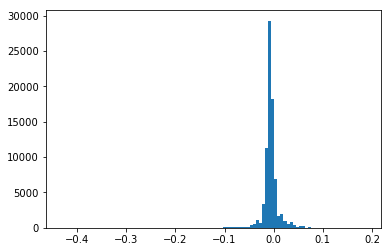

In [50]:
plt.hist(fs.y-y_train,bins=100);

In [80]:
np.mean(fs.y),np.median(fs.y),np.mean(trainy)

(0.0054871434510978465, 0.00032101243777940894, 0.01081647157282662)

In [81]:
mae(fs.y)

0.06751850698070253

In [104]:
condsDF=sc.parallelize(cond_lists[:30],1000)

In [153]:
eval_results=condsDF.map(lambda u: evaluate_cond(u,X=Xy_bc.value[0],y=Xy_bc.value[1])).collect()

In [154]:
len(x_train)

80000

In [155]:
df=pd.DataFrame(eval_results,columns=['n','gain','m','sd','p'])
df=df.sort_values("gain",ascending=False)

In [156]:
df[df['p']<0.05]

n          gain         m        sd         p
5   1268.0  1.769818e-05  0.014583  0.001881  0.000000
21  1719.0  1.048334e-05  0.005703  0.001355  0.000026
20    82.0  7.805122e-06  0.042289  0.008920  0.000002
27   703.0  5.189973e-06  0.006083  0.002515  0.015573
4   1212.0  3.832921e-06  0.003765  0.001548  0.014991
22   150.0  3.128936e-06  0.020587  0.003332  0.000000
12   136.0  2.348593e-06  0.015604  0.006976  0.025300
1    146.0  1.909942e-06  0.016727  0.005591  0.002776
16    53.0  1.296412e-06  0.031100  0.007196  0.000015
19   314.0  1.018784e-06  0.005722  0.002257  0.011228
24    72.0 -5.924227e-07 -0.011321  0.005133  0.027417
9    372.0 -9.794574e-06 -0.017206  0.005743  0.002737
26  3148.0 -1.012016e-05 -0.003257  0.000835  0.000095
29  5619.0 -1.949563e-05 -0.003744  0.000794  0.000002
18  2215.0 -4.721819e-05 -0.011069  0.002089  0.000000

In [158]:
df.gain.sum()*1000

-0.023877345226686053